## ELETTRA-03: ORM construction

In [1]:
# In this example correctors are inserted and ORM is constructed

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.corrector import Corrector

from model.command.external import load_lattice
from model.command.build import build
from model.command.orbit import ORM

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Define list of element names with trim coils
# Note, individual correctors are added separatly

names = ['SD_S01_01', 'SD_S01_02', 'SD_S01_03', 'SD_S01_04', 'SD_S01_07', 'SD_S01_08', 'SD_S01_09', 'SD_S01_10', 'SF_S01_01', 'SF_S01_06', 'SH_S01_01', 'SH_S01_04', 'OCT_S01_01', 'OCT_S01_04', 'SD_S02_01', 'SD_S02_02', 'SD_S02_03', 'SD_S02_04', 'SD_S02_07', 'SD_S02_08', 'SD_S02_09', 'SD_S02_10', 'SF_S02_01', 'SF_S02_06', 'SH_S02_01', 'SH_S02_04', 'OCT_S02_01', 'OCT_S02_04', 'SD_S03_01', 'SD_S03_02', 'SD_S03_03', 'SD_S03_04', 'SD_S03_07', 'SD_S03_08', 'SD_S03_09', 'SD_S03_10', 'SF_S03_01', 'SF_S03_06', 'SH_S03_01', 'SH_S03_04', 'OCT_S03_01', 'OCT_S03_04', 'SD_S04_01', 'SD_S04_02', 'SD_S04_03', 'SD_S04_04', 'SD_S04_07', 'SD_S04_08', 'SD_S04_09', 'SD_S04_10', 'SF_S04_01', 'SF_S04_06', 'SH_S04_01', 'SH_S04_04', 'OCT_S04_01', 'OCT_S04_04', 'SD_S05_01', 'SD_S05_02', 'SD_S05_03', 'SD_S05_04', 'SD_S05_07', 'SD_S05_08', 'SD_S05_09', 'SD_S05_10', 'SF_S05_01', 'SF_S05_06', 'SH_S05_01', 'SH_S05_04', 'OCT_S05_01', 'OCT_S05_04', 'SD_S06_01', 'SD_S06_02', 'SD_S06_03', 'SD_S06_04', 'SD_S06_07', 'SD_S06_08', 'SD_S06_09', 'SD_S06_10', 'SF_S06_01', 'SF_S06_06', 'SH_S06_01', 'SH_S06_04', 'OCT_S06_01', 'OCT_S06_04', 'SD_S07_01', 'SD_S07_02', 'SD_S07_03', 'SD_S07_04', 'SD_S07_07', 'SD_S07_08', 'SD_S07_09', 'SD_S07_10', 'SF_S07_01', 'SF_S07_06', 'SH_S07_01', 'SH_S07_04', 'OCT_S07_01', 'OCT_S07_04', 'SD_S08_01', 'SD_S08_02', 'SD_S08_03', 'SD_S08_04', 'SD_S08_07', 'SD_S08_08', 'SD_S08_09', 'SD_S08_10', 'SF_S08_01', 'SF_S08_06', 'SH_S08_01', 'SH_S08_04', 'OCT_S08_01', 'OCT_S08_04', 'SD_S09_01', 'SD_S09_02', 'SD_S09_03', 'SD_S09_04', 'SD_S09_07', 'SD_S09_08', 'SD_S09_09', 'SD_S09_10', 'SF_S09_01', 'SF_S09_06', 'SH_S09_01', 'SH_S09_04', 'OCT_S09_01', 'OCT_S09_04', 'SD_S10_01', 'SD_S10_02', 'SD_S10_03', 'SD_S10_04', 'SD_S10_07', 'SD_S10_08', 'SD_S10_09', 'SD_S10_10', 'SF_S10_01', 'SF_S10_06', 'SH_S10_01', 'SH_S10_04', 'OCT_S10_01', 'OCT_S10_04', 'SD_S11_01', 'SD_S11_02', 'SD_S11_03', 'SD_S11_04', 'SD_S11_07', 'SD_S11_08', 'SD_S11_09', 'SD_S11_10', 'SF_S11_01', 'SF_S11_06', 'SH_S11_01', 'SH_S11_04', 'OCT_S11_01', 'OCT_S11_04', 'SD_S12_01', 'SD_S12_02', 'SD_S12_03', 'SD_S12_04', 'SD_S12_07', 'SD_S12_08', 'SD_S12_09', 'SD_S12_10', 'SF_S12_01', 'SF_S12_06', 'SH_S12_01', 'SH_S12_04', 'OCT_S12_01', 'OCT_S12_04']

In [6]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles


def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH'):
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])
        continue    
    if name in names:
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector]) 

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 732,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 192,
 'Marker': 12}

In [7]:
# Compute ORM (2*168 x 2*192)

orbit = torch.tensor(4*[0.0], dtype=dtype)
orm = ORM(ring, orbit, [], limit=1)
print(orm.shape)

torch.Size([336, 384])


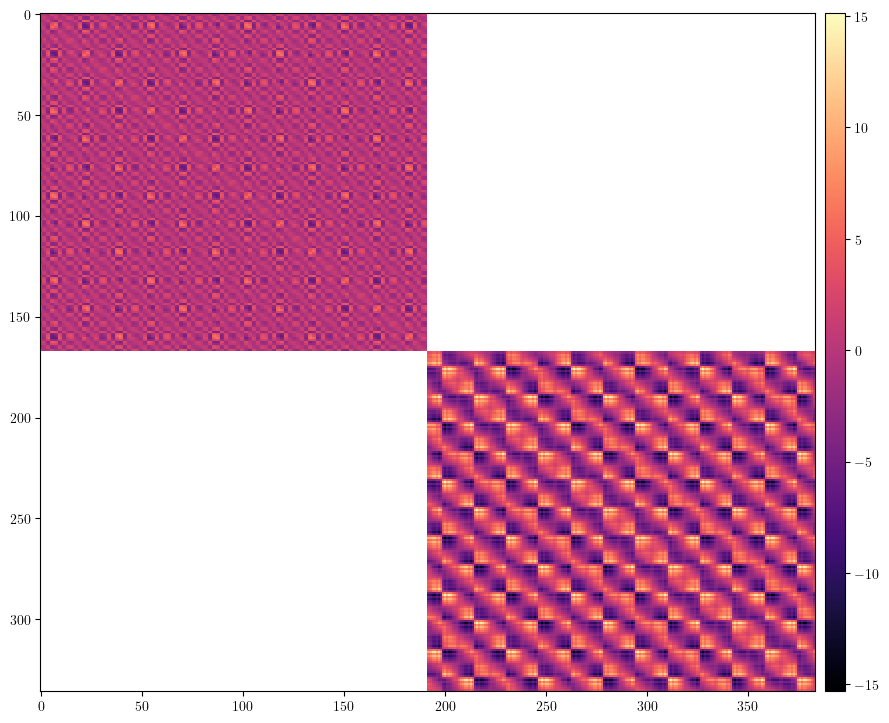

In [8]:
# Plot ORM (exclude skew blocks)

# RXX RXY
# RYX RYY

data = orm.clone()
data[data==0.0] = torch.nan

plt.figure(figsize=(10, 10))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()